In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statistics import mean
from sklearn.metrics import mean_squared_error as mse
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn import metrics

from xgboost import XGBRegressor

from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout 
from keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
from sklearn.feature_selection import SelectKBest,chi2,RFE

pd.set_option('display.max_columns', 100)
sns.set_style('darkgrid')

**Import dataset**

In [ ]:
URL = 'https://drive.google.com/file/d/1YVT57kBOTaliCH30hYG_xFZ3kC_FABfr/view?usp=sharing'
path = 'https://drive.google.com/uc?ex}port=download&id='+URL.split('/')[-2]
df = pd.read_csv(path)
df.head()

,Country,Partner,ParternType,Bank,BankAccount,invoiceNumber,InvoiceDate,DueDate,PaymentTerms,InvoiceCurrency,InvoiceAmount,SettlmentCurrency,CurrencyPair,SettlementAmount,SettledAmountUSD,SettledDate,DocumentType
0,Australia,SCT Logistics,Supplier,National Australian Bank (NAB),72236140,3714895880,12/1/2018,11/2/2018,30.0,AUD,92.862,AUD,AUD/AUD,92.86,133.21,9/2/2018,Purchase Invoice
1,Australia,G&S Logistics,Supplier,National Australian Bank (NAB),72236140,3267863711,15/1/2018,14/2/2018,30.0,AUD,51.795,AUD,AUD/AUD,51.80,74.31,13/2/2018,Purchase Invoice
2,Australia,CEVA Logistics,Supplier,National Australian Bank (NAB),72236140,2110257500,31/1/2018,2/3/2018,30.0,AUD,15.463,AUD,AUD/AUD,15.46,22.18,13/3/2018,Purchase Invoice
3,Australia,UC Logistics Australia,Supplier,National Australian Bank (NAB),72236140,700682941,15/2/2018,16/3/2018,29.0,AUD,52.536,AUD,AUD/AUD,52.54,75.37,15/3/2018,Purchase Invoice
4,Australia,SCT Logistics,Supplier,National Australian Bank (NAB),72236140,6546749565,16/2/2018,17/3/2018,29.0,AUD,49.140,AUD,AUD/AUD,49.14,70.49,28/3/2018,Purchase Invoice


**Data Cleaning**

In [ ]:
print("shape of dataset before cleaning:", df.shape)
print(df.dtypes)
df.isna().any()
df = df.dropna()
print("shape of dataset after cleaning:", df.shape)

# Change Date format to time series
df['SettledDate'] = pd.to_datetime(df['SettledDate'], format='%d/%m/%Y')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d/%m/%Y')
df['DueDate'] = pd.to_datetime(df['DueDate'], format='%d/%m/%Y')

# Time gap between settled date and invoice date
df['Settle_Invoice']= df.SettledDate - df.InvoiceDate
df['Settle_Invoice'] = df['Settle_Invoice'].dt.days

# Time gap between settled date and due date
df['Settle_Due']= df.SettledDate - df.DueDate
df['Settle_Due'] = df['Settle_Due'].dt.days

# Cashflow
# Convert all invoice amount to USD

df[df["InvoiceCurrency"]=="AUD"]["InvoiceAmount"] = df[df["InvoiceCurrency"]=="AUD"]["InvoiceAmount"]*0.75
df[df["InvoiceCurrency"]=="CHF"]["InvoiceAmount"] = df[df["InvoiceCurrency"]=="CHF"]["InvoiceAmount"]*1.08
df[df["InvoiceCurrency"]=="EUR"]["InvoiceAmount"] = df[df["InvoiceCurrency"]=="EUR"]["InvoiceAmount"]*1.11
df[df["InvoiceCurrency"]=="JPY"]["InvoiceAmount"] = df[df["InvoiceCurrency"]=="JPY"]["InvoiceAmount"]*0.0082
df[df["InvoiceCurrency"]=="SGD"]["InvoiceAmount"] = df[df["InvoiceCurrency"]=="SGD"]["InvoiceAmount"]*0.74

df["InvoiceAmountUSD"] = df["InvoiceAmount"]


shape of dataset before cleaning: (7021, 19)
Country                      object
Partner                      object
ParternType                  object
Bank                         object
BankAccount                   int64
invoiceNumber                 int64
InvoiceDate          datetime64[ns]
DueDate              datetime64[ns]
PaymentTerms                float64
InvoiceCurrency              object
InvoiceAmount               float64
SettlmentCurrency            object
CurrencyPair                 object
SettlementAmount            float64
SettledAmountUSD            float64
SettledDate          datetime64[ns]
DocumentType                 object
Settle_Invoice                int64
Settle_Due                    int64
dtype: object
shape of dataset after cleaning: (7021, 19)


In [ ]:
df["cashflow"] = df["SettledAmountUSD"] - df["InvoiceAmountUSD"]
df

,Country,Partner,ParternType,Bank,BankAccount,invoiceNumber,InvoiceDate,DueDate,PaymentTerms,InvoiceCurrency,InvoiceAmount,SettlmentCurrency,CurrencyPair,SettlementAmount,SettledAmountUSD,SettledDate,DocumentType,Settle_Invoice,Settle_Due,InvoiceAmountUSD,cashflow
0,Australia,SCT Logistics,Supplier,National Australian Bank (NAB),72236140,3714895880,2018-01-12,2018-02-11,30.0,AUD,92.862,AUD,AUD/AUD,92.86,133.21,2018-02-09,Purchase Invoice,28,-2,92.862,40.348
1,Australia,G&S Logistics,Supplier,National Australian Bank (NAB),72236140,3267863711,2018-01-15,2018-02-14,30.0,AUD,51.795,AUD,AUD/AUD,51.80,74.31,2018-02-13,Purchase Invoice,29,-1,51.795,22.515
2,Australia,CEVA Logistics,Supplier,National Australian Bank (NAB),72236140,2110257500,2018-01-31,2018-03-02,30.0,AUD,15.463,AUD,AUD/AUD,15.46,22.18,2018-03-13,Purchase Invoice,41,11,15.463,6.717
3,Australia,UC Logistics Australia,Supplier,National Australian Bank (NAB),72236140,700682941,2018-02-15,2018-03-16,29.0,AUD,52.536,AUD,AUD/AUD,52.54,75.37,2018-03-15,Purchase Invoice,28,-1,52.536,22.834
4,Australia,SCT Logistics,Supplier,National Australian Bank (NAB),72236140,6546749565,2018-02-16,2018-03-17,29.0,AUD,49.140,AUD,AUD/AUD,49.14,70.49,2018-03-28,Purchase Invoice,40,11,49.140,21.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7461,Switzerland,Good Health Distributors Pte Ltd,Customer,ING,85376964,784468555,2020-09-25,2020-10-25,30.0,USD,18.900,USD,USD/USD,18.90,18.90,2020-10-25,Sales Invoice,30,0,18.900,0.000
7462,Singapore,Music Distributors (S) Pte Ltd,Customer,UBS,72715155,6478764177,2020-10-04,2020-11-03,30.0,USD,64.720,USD,USD/USD,64.72,64.72,2020-10-26,Sales Invoice,22,-8,64.720,0.000
7463,Japan,Integrity Distribution Pte Ltd,Customer,The Norinchukin Bank,89164178,9923599437,2020-10-04,2020-11-03,30.0,USD,76.180,USD,USD/USD,76.18,76.18,2020-10-27,Sales Invoice,23,-7,76.180,0.000
7464,Japan,Marketasia Distributors (S) Pte Ltd,Customer,ING,66087938,4871103320,2020-10-18,2020-11-17,30.0,USD,59.070,USD,USD/USD,59.07,59.07,2020-10-27,Sales Invoice,9,-21,59.070,0.000


In [ ]:
df1 = df.set_index('InvoiceDate')

# to_datetime() method converts string
# format to a DateTime object
df1.index = pd.to_datetime(df1.index)
max(df1.index)
# dates which are not in the sequence
# are returned
print(pd.date_range(start="2018-01-03", end="2020-10-24").difference(df1.index))

idx = pd.date_range(start="2018-01-03", end="2020-10-24")
# df1.reindex(idx, fill_value=0)


DatetimeIndex(['2018-01-05', '2018-04-05', '2019-12-21', '2020-08-06',
               '2020-10-01', '2020-10-08', '2020-10-09', '2020-10-10',
               '2020-10-15', '2020-10-16', '2020-10-20', '2020-10-23'],
              dtype='datetime64[ns]', freq=None)


We first perform some data cleaning, such as formalisation of the datatime format and imputation of missing values.

In [ ]:
df_partner = df.groupby("Partner").mean()
df_partner

,BankAccount,invoiceNumber,PaymentTerms,InvoiceAmount,SettlementAmount,SettledAmountUSD,Settle_Invoice,Settle_Due,InvoiceAmountUSD,cashflow
Partner,,,,,,,,,,
DB Schenker Logistics Company,53068712.0,4.575455e+09,30.036364,70.429982,70.430182,70.430182,21.709091,-8.327273,70.429982,0.000200
DHL Logistics Company,53068712.0,3.897148e+09,30.052632,56.087711,56.087895,56.087895,33.736842,3.684211,56.087711,0.000184
DTDC eCommerce Logistics Services,53068712.0,4.593469e+09,30.022222,52.240156,52.240889,52.240889,16.977778,-13.044444,52.240156,0.000733
FedEx Logistics Partner,53068712.0,4.616783e+09,30.000000,67.226235,67.226176,67.226176,29.735294,-0.264706,67.226235,-0.000059
Singapore Post Logistics Service,53068712.0,4.399158e+09,30.000000,54.826326,54.826512,54.826512,24.860465,-5.139535,54.826326,0.000186
...,...,...,...,...,...,...,...,...,...,...
Transcontainer Limited,63275025.0,4.182405e+09,29.960000,78.490380,7848.980000,68.286000,25.880000,-4.080000,78.490380,-10.204380
Transgesa,53068712.0,5.809558e+09,29.902439,50.025195,50.025366,67.373902,31.268293,1.365854,50.025195,17.348707
UC Logistics Australia,72236140.0,3.603228e+09,30.000000,65.400300,65.400750,93.817250,32.175000,2.175000,65.400300,28.416950


In [ ]:
df_partner["Invoice Count"]= df.groupby('Partner').size()

In [ ]:
df_partner

,BankAccount,invoiceNumber,PaymentTerms,InvoiceAmount,SettlementAmount,SettledAmountUSD,Settle_Invoice,Settle_Due,InvoiceAmountUSD,cashflow,Invoice Count
Partner,,,,,,,,,,,
DB Schenker Logistics Company,53068712.0,4.575455e+09,30.036364,70.429982,70.430182,70.430182,21.709091,-8.327273,70.429982,0.000200,55
DHL Logistics Company,53068712.0,3.897148e+09,30.052632,56.087711,56.087895,56.087895,33.736842,3.684211,56.087711,0.000184,38
DTDC eCommerce Logistics Services,53068712.0,4.593469e+09,30.022222,52.240156,52.240889,52.240889,16.977778,-13.044444,52.240156,0.000733,45
FedEx Logistics Partner,53068712.0,4.616783e+09,30.000000,67.226235,67.226176,67.226176,29.735294,-0.264706,67.226235,-0.000059,34
Singapore Post Logistics Service,53068712.0,4.399158e+09,30.000000,54.826326,54.826512,54.826512,24.860465,-5.139535,54.826326,0.000186,43
...,...,...,...,...,...,...,...,...,...,...,...
Transcontainer Limited,63275025.0,4.182405e+09,29.960000,78.490380,7848.980000,68.286000,25.880000,-4.080000,78.490380,-10.204380,50
Transgesa,53068712.0,5.809558e+09,29.902439,50.025195,50.025366,67.373902,31.268293,1.365854,50.025195,17.348707,41
UC Logistics Australia,72236140.0,3.603228e+09,30.000000,65.400300,65.400750,93.817250,32.175000,2.175000,65.400300,28.416950,40


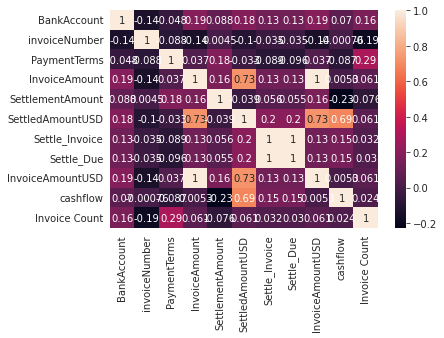

In [ ]:
corrMatrix = df_partner.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

**EDA**

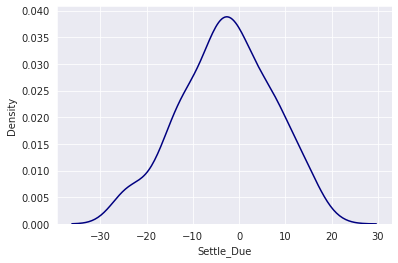

In [ ]:
sns.distplot(df_partner['Settle_Due'], color= 'navy', hist=False)

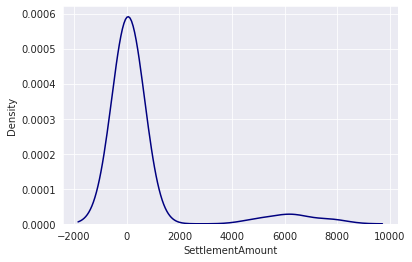

In [ ]:
sns.distplot(df_partner['SettlementAmount'], color= 'navy', hist=False)

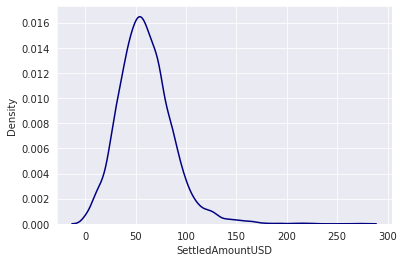

In [ ]:
sns.distplot(df['SettledAmountUSD'], color= 'navy', hist=False)

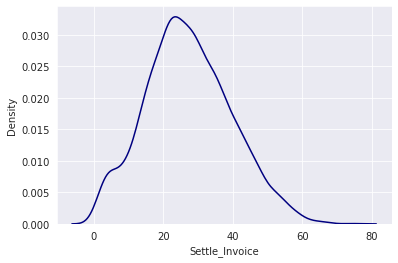

In [ ]:
sns.distplot(df['Settle_Invoice'], color= 'navy', hist=False)

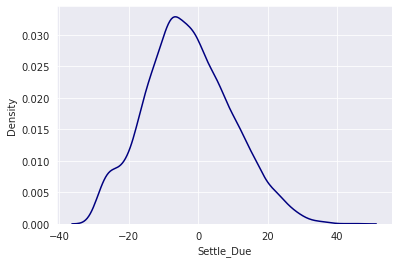

In [ ]:
sns.distplot(df['Settle_Due'], color= 'navy', hist=False)


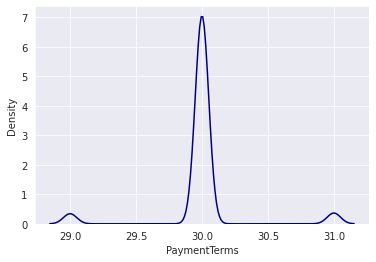

In [ ]:
sns.distplot(df['PaymentTerms'], color= 'navy', hist=False)

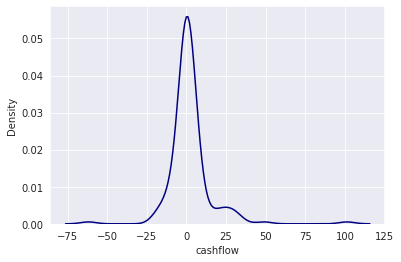

In [ ]:
sns.distplot(df_partner['cashflow'], color= 'navy', hist=False)

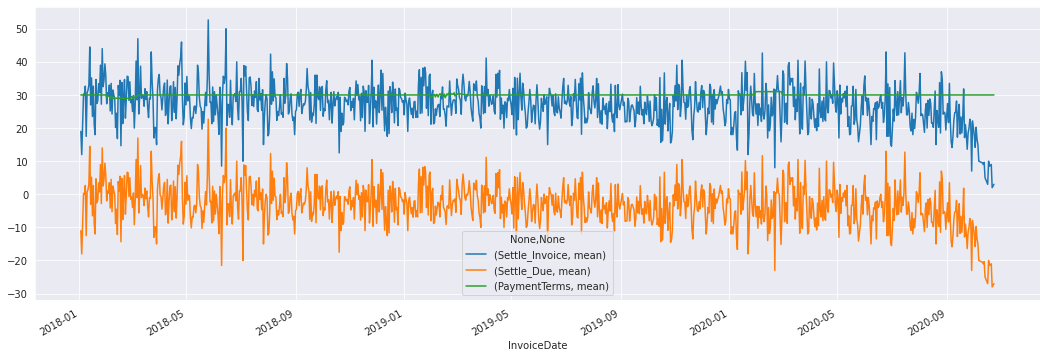

In [ ]:
# set the dataframe index as invoice_date
# There are duplicates in invoiceDate, we take mean Settle_Invoice

df_new = df.groupby('InvoiceDate').agg({'Settle_Invoice': ['mean'],'Settle_Due': ['mean'],'PaymentTerms':['mean']})
df_new.plot(figsize=(18,6))


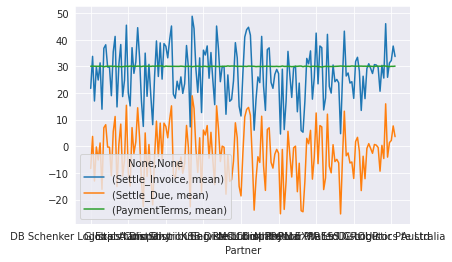

In [ ]:
df_new_partner = df.groupby('Partner').agg({'Settle_Invoice': ['mean'],'Settle_Due': ['mean'],'PaymentTerms':['mean']})
df_new_partner.plot()


In [ ]:
df_new_partner

,Settle_Invoice,Settle_Due,PaymentTerms
,mean,mean,mean
Partner,,,
DB Schenker Logistics Company,21.709091,-8.327273,30.036364
DHL Logistics Company,33.736842,3.684211,30.052632
DTDC eCommerce Logistics Services,16.977778,-13.044444,30.022222
FedEx Logistics Partner,29.735294,-0.264706,30.000000
Singapore Post Logistics Service,24.860465,-5.139535,30.000000
...,...,...,...
Transcontainer Limited,25.880000,-4.080000,29.960000
Transgesa,31.268293,1.365854,29.902439


In [ ]:
percentage_of_late_invoices = len(df[df["Settle_Due"]>0])/len(df)*100
percentage_of_late_invoices

37.60148127047429

In [ ]:
mean(df["Settle_Due"])

-2.7514599059962968

In [ ]:
mean(df_partner["Invoice Count"])

43.07361963190184

In [ ]:
df['CurrencyPair'].unique()

array(['AUD/AUD', 'AUD/USD', 'CHF/CHF', 'CHF/USD', 'EUR/AUD', 'EUR/CHF',
       'EUR/EUR', 'EUR/USD', 'GBP/AUD', 'GBP/USD', 'JPY/JPY', 'JPY/USD',
       'SGD/SGD', 'USD/AUD', 'USD/CHF', 'USD/EUR', 'USD/SGD', 'USD/USD'],
      dtype=object)

In [ ]:
df["InvoiceCurrency"].unique()

array(['AUD', 'USD', 'CHF', 'EUR', 'JPY', 'SGD'], dtype=object)

In [ ]:
#top 5 firms most likely to pay late
df_partner.sort_values("Settle_Due",ascending=False).head(5).index

Index(['Hi-Tech Distribution Pte Ltd', 'Toll Global Forwarding', 'Daily Fresh',
       'Isewan Terminal Service', 'Gondrand SPA'],
      dtype='object', name='Partner')

1. Across all the invoices listed, 37.6% of them are late. 
2. Across all the invoices, the average date of payment is two days behind the due date. 
3. On average, each partner has 43 invoices.
4. The top five firms most likely to pay late are 'Hi-Tech Distribution Pte Ltd', 'Toll Global Forwarding', 'Daily Fresh',  'Isewan Terminal Service' and 'Gondrand SPA'.


**Logistic regression**

I use logistic regression to predict whether a transaction will be overdue or not. Hope this information will be useful haha.


In [ ]:

# # Select last 14 days for prediction
df_test = df[(df["InvoiceDate"].max() - df["InvoiceDate"]).dt.days <= 14]
df_train = df[(df["InvoiceDate"].max() - df["InvoiceDate"]).dt.days > 14]
print("df_train shape: ", df_train.shape)
print("df_test shape: ", df_test.shape)

df_train['OverDue'] = np.where(df_train['Settle_Due'] < 0 , 1, 0)

df_dummies = pd.get_dummies(df_train)

features= ['Country','Partner','ParternType','Bank','PaymentTerms','Settle_Invoice']

X = pd.get_dummies(df_train[features])
Y = df_dummies['OverDue']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

model = LogisticRegression()
result = model.fit(X_train, Y_train)

prediction_test = model.predict(X_test)

# Print the prediction accuracy
print ("Accuracy score: ", metrics.accuracy_score(Y_test, prediction_test))

np.mean((model.predict(X_test) > 0.5) == Y_test)

df_train shape:  (7002, 19)
df_test shape:  (19, 19)
Accuracy score:  1.0


1.0

**XGBoost**

In [ ]:
# transform a time series dataset into a supervised learning dataset
# 1 day shift = 1 day horizon
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = data
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values


In [ ]:
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [ ]:
def xgboost_forecast(train, testX):
# transform list into array
  train = np.asarray(train)
# split into input and output columns
  trainX, trainy = train[:, :-1], train[:, -1]
# fit model	
  model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
  model.fit(trainX, trainy)
# make a one-step prediction
  yhat = model.predict(np.asarray([testX]))
  return yhat[0]


In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	rmse = math.sqrt(mse(test[:, -1], predictions))
	return rmse, test[:, -1], predictions


In [ ]:
# evaluate
data = series_to_supervised(df[["Settle_Invoice"]],n_in=1, n_out=1)
rmse, y, yhat = walk_forward_validation(data, 14)
print('RMSE: %.3f' % rmse)


>expected=5.0, predicted=27.2
>expected=41.0, predicted=25.3
>expected=36.0, predicted=27.8
>expected=9.0, predicted=27.7
>expected=21.0, predicted=26.8
>expected=30.0, predicted=27.7
>expected=12.0, predicted=27.3
>expected=31.0, predicted=25.1
>expected=34.0, predicted=27.7
>expected=30.0, predicted=26.9
>expected=22.0, predicted=27.3
>expected=23.0, predicted=26.8
>expected=9.0, predicted=28.2
>expected=29.0, predicted=26.7
RMSE: 11.745


In [ ]:
# evaluate
data = series_to_supervised(df[["Settle_Invoice"]],n_in=2, n_out=2)
rmse, y, yhat = walk_forward_validation(data, 14)
print('RMSE: %.3f' % rmse)


>expected=5.0, predicted=27.1
>expected=41.0, predicted=21.2
>expected=36.0, predicted=27.0
>expected=9.0, predicted=22.3
>expected=21.0, predicted=26.0
>expected=30.0, predicted=29.7
>expected=12.0, predicted=23.1
>expected=31.0, predicted=25.8
>expected=34.0, predicted=26.9
>expected=30.0, predicted=25.9
>expected=22.0, predicted=28.0
>expected=23.0, predicted=27.1
>expected=9.0, predicted=27.6
>expected=29.0, predicted=28.6
RMSE: 11.277


In [ ]:
# evaluate
data = series_to_supervised(df[["Settle_Invoice"]],n_in=3, n_out=3)
rmse, y, yhat = walk_forward_validation(data, 14)
print('RMSE: %.3f' % rmse)


>expected=5.0, predicted=26.2
>expected=41.0, predicted=26.9
>expected=36.0, predicted=27.7
>expected=9.0, predicted=26.1
>expected=21.0, predicted=26.5
>expected=30.0, predicted=28.1
>expected=12.0, predicted=27.7
>expected=31.0, predicted=25.3
>expected=34.0, predicted=26.4
>expected=30.0, predicted=27.1
>expected=22.0, predicted=28.4
>expected=23.0, predicted=26.7
>expected=9.0, predicted=26.5
>expected=29.0, predicted=28.7
RMSE: 11.178


In [ ]:
# evaluate
data = series_to_supervised(df[["Settle_Due"]],n_in=3, n_out=3)
rmse, y, yhat = walk_forward_validation(data, 14)
print('RMSE: %.3f' % rmse)

>expected=-25.0, predicted=-1.7
>expected=11.0, predicted=-7.0
>expected=6.0, predicted=2.3
>expected=-21.0, predicted=-4.5
>expected=-9.0, predicted=-5.4
>expected=0.0, predicted=-4.4
>expected=-18.0, predicted=-4.5
>expected=1.0, predicted=-4.5
>expected=4.0, predicted=-3.9
>expected=0.0, predicted=-3.6
>expected=-8.0, predicted=0.1
>expected=-7.0, predicted=-2.6
>expected=-21.0, predicted=-1.4
>expected=-1.0, predicted=-2.6
RMSE: 11.791


In [ ]:
data = series_to_supervised(df[["cashflow"]],n_in=3, n_out=3)
rmse, y, yhat = walk_forward_validation(data, 14)
print('RMSE: %.3f' % rmse)

>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.0
RMSE: 0.003


**LSTM**

https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/

In [ ]:

features= ['Country','Partner','ParternType','Bank','PaymentTerms','Settle_Invoice']

X = pd.get_dummies(df[features])
Y = df[['Settle_Invoice']]

# Feature extraction
model = LinearRegression()
rfe = RFE(model,n_features_to_select=10)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))

newX = X[fit.get_feature_names_out()]
print(fit.get_feature_names_out())
newX.head()

Num Features: 10
['Settle_Invoice' 'Partner_Golden Harvest Distribution Pte Ltd'
 'Partner_Henry Johnson Sons and Co Ltd'
 'Partner_Hup Heng Hiong Joss-Stick Distributor Company'
 'Partner_Japfa Food Distributors Pte Ltd'
 'Partner_LKH Power Distribution Pte Ltd'
 'Partner_Laser Distributor Pte Ltd'
 'Partner_Makmur Food Distributor Pte Ltd'
 'Partner_Mercury Freight Distribution Pte Ltd'
 'Bank_National Australian Bank (NAB)']


,Settle_Invoice,Partner_Golden Harvest Distribution Pte Ltd,Partner_Henry Johnson Sons and Co Ltd,Partner_Hup Heng Hiong Joss-Stick Distributor Company,Partner_Japfa Food Distributors Pte Ltd,Partner_LKH Power Distribution Pte Ltd,Partner_Laser Distributor Pte Ltd,Partner_Makmur Food Distributor Pte Ltd,Partner_Mercury Freight Distribution Pte Ltd,Bank_National Australian Bank (NAB)
0,28,0,0,0,0,0,0,0,0,1
1,29,0,0,0,0,0,0,0,0,1
2,41,0,0,0,0,0,0,0,0,1
3,28,0,0,0,0,0,0,0,0,1
4,40,0,0,0,0,0,0,0,0,1


In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50
np_data_scaled = newX
# Prediction Index
index_Close = np_data_scaled.columns.get_loc("Settle_Invoice")

train_data_len = np_data_scaled.shape[0] - 14

train_data = np_data_scaled.iloc[0:train_data_len, :]
test_data = np_data_scaled.iloc[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data.iloc[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data.iloc[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(6957, 50, 10) (6957,)
(14, 50, 10) (14,)
31
31


In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')


500 50 10


In [ ]:
# Training the model
epochs = 5
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/5
435/435 [==============================] - 410s 943ms/step - loss: 153.1585 - val_loss: 126.4044
Epoch 2/5
435/435 [==============================] - 442s 1s/step - loss: 153.0023 - val_loss: 135.5387
Epoch 3/5
435/435 [==============================] - 432s 994ms/step - loss: 153.1268 - val_loss: 123.9813
Epoch 4/5
435/435 [==============================] - 432s 993ms/step - loss: 153.0752 - val_loss: 135.8312
Epoch 5/5
435/435 [==============================] - 419s 964ms/step - loss: 153.1331 - val_loss: 147.3488


In [ ]:
y_pred= model.predict(x_test)

# Mean Absolute Error (MAE)
RMSE = math.sqrt(mse(y_test, y_pred))
print(f'RMSE: {np.round(RMSE, 2)}')


RMSE: 12.14


Auto ARIMA

https://betterprogramming.pub/using-auto-arima-with-python-e482e322f430

In [ ]:
!pip install numpy --upgrade
!pip install scipy --upgrade
!pip install sklearn --upgrade
!pip install pandas --upgrade


     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

     |████████████████████████████████| 1.4 MB 3.3 MB/s 
     |████████████████████████████████| 9.8 MB 38.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
df

,Country,Partner,ParternType,Bank,BankAccount,invoiceNumber,InvoiceDate,DueDate,PaymentTerms,InvoiceCurrency,InvoiceAmount,SettlmentCurrency,CurrencyPair,SettlementAmount,SettledAmountUSD,SettledDate,DocumentType,Settle_Invoice,Settle_Due
0,Australia,SCT Logistics,Supplier,National Australian Bank (NAB),72236140,3714895880,2018-01-12,2018-02-11,30.0,AUD,92.862,AUD,AUD/AUD,92.86,133.21,2018-02-09,Purchase Invoice,28,-2
1,Australia,G&S Logistics,Supplier,National Australian Bank (NAB),72236140,3267863711,2018-01-15,2018-02-14,30.0,AUD,51.795,AUD,AUD/AUD,51.80,74.31,2018-02-13,Purchase Invoice,29,-1
2,Australia,CEVA Logistics,Supplier,National Australian Bank (NAB),72236140,2110257500,2018-01-31,2018-03-02,30.0,AUD,15.463,AUD,AUD/AUD,15.46,22.18,2018-03-13,Purchase Invoice,41,11
3,Australia,UC Logistics Australia,Supplier,National Australian Bank (NAB),72236140,700682941,2018-02-15,2018-03-16,29.0,AUD,52.536,AUD,AUD/AUD,52.54,75.37,2018-03-15,Purchase Invoice,28,-1
4,Australia,SCT Logistics,Supplier,National Australian Bank (NAB),72236140,6546749565,2018-02-16,2018-03-17,29.0,AUD,49.140,AUD,AUD/AUD,49.14,70.49,2018-03-28,Purchase Invoice,40,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7461,Switzerland,Good Health Distributors Pte Ltd,Customer,ING,85376964,784468555,2020-09-25,2020-10-25,30.0,USD,18.900,USD,USD/USD,18.90,18.90,2020-10-25,Sales Invoice,30,0
7462,Singapore,Music Distributors (S) Pte Ltd,Customer,UBS,72715155,6478764177,2020-10-04,2020-11-03,30.0,USD,64.720,USD,USD/USD,64.72,64.72,2020-10-26,Sales Invoice,22,-8
7463,Japan,Integrity Distribution Pte Ltd,Customer,The Norinchukin Bank,89164178,9923599437,2020-10-04,2020-11-03,30.0,USD,76.180,USD,USD/USD,76.18,76.18,2020-10-27,Sales Invoice,23,-7
7464,Japan,Marketasia Distributors (S) Pte Ltd,Customer,ING,66087938,4871103320,2020-10-18,2020-11-17,30.0,USD,59.070,USD,USD/USD,59.07,59.07,2020-10-27,Sales Invoice,9,-21


In [ ]:
univariate_ser = df.set_index("InvoiceDate")["Settle_Due"]
univariate_ser

InvoiceDate
2018-01-12    -2
2018-01-15    -1
2018-01-31    11
2018-02-15    -1
2018-02-16    11
              ..
2020-09-25     0
2020-10-04    -8
2020-10-04    -7
2020-10-18   -21
2020-09-30    -1
Name: Settle_Due, Length: 7021, dtype: int64

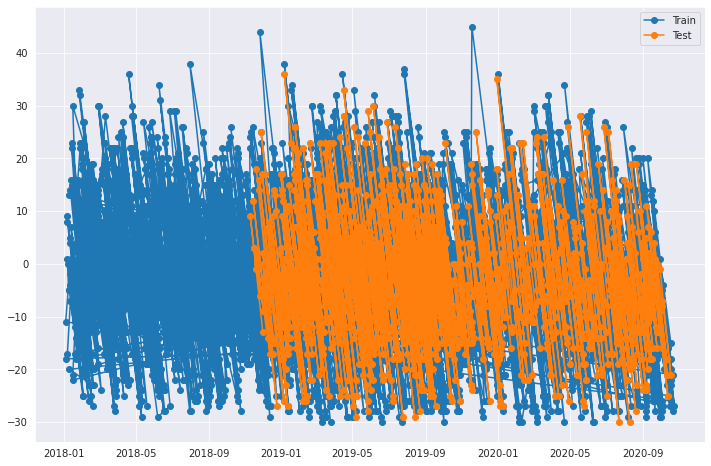

In [ ]:

# Train Test Split Index
train_size = 0.8
split_idx = round(len(univariate_ser)* train_size)
split_idx

# Split
train = univariate_df.iloc[:split_idx]
test = univariate_df.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [ ]:
arima_model = auto_arima(train, start_p=0, start_q=0)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5617
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -22119.327
Date:                Mon, 14 Mar 2022   AIC                          44246.654
Time:                        15:22:11   BIC                          44273.187
Sample:                             0   HQIC                         44255.899
                               - 5617                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0270      0.013      2.126      0.033       0.002       0.052
ar.L2          0.0288      0.013      2.256      0.024       0.004       0.054
ma.L1         -0.9894      0.002   -477.344      0.000      -0.993      -0.985
sigma2       154.2705      3.063     50.360      0.000     148.266     160.275
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                57.75
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

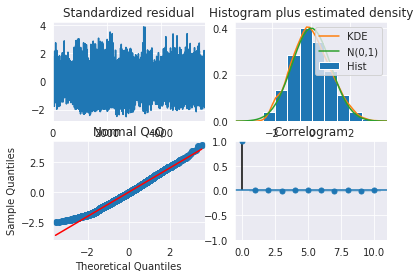

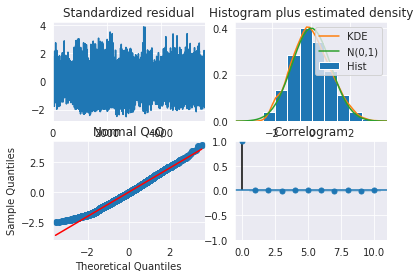

In [ ]:
arima_model.plot_diagnostics()

In [ ]:
!pip install statsmodels --upgrade
def forecast_to_df(model, steps=12):
    forecast = model.get_forecast(steps=steps)
    pred_df = forecast.conf_int()
    pred_df['pred'] = forecast.predicted_mean
    pred_df.columns = ['lower', 'upper', 'pred']
    return pred_df

In [ ]:
future_forecast = arima_model.predict(n_periods=30)
future_forecast

array([-3.75928901, -3.59087269, -3.40643385, -3.39660171, -3.39101977,
       -3.39058571, -3.39041309, -3.39039592, -3.39039048, -3.39038984,
       -3.39038966, -3.39038964, -3.39038963, -3.39038963, -3.39038963,
       -3.39038963, -3.39038963, -3.39038963, -3.39038963, -3.39038963,
       -3.39038963, -3.39038963, -3.39038963, -3.39038963, -3.39038963,
       -3.39038963, -3.39038963, -3.39038963, -3.39038963, -3.39038963])

In [ ]:
pred= arima_model.predict(len(test))

# Mean Absolute Error (MAE)
RMSE = math.sqrt(mse(test, pred))
print(f'RMSE: {np.round(RMSE, 2)}')


RMSE: 11.63


**DeepAR**

https://kekayan.medium.com/forecasting-with-deepar-for-busy-people-ed67f9d9a00d

https://ts.gluon.ai/tutorials/forecasting/quick_start_tutorial.html

In [ ]:
univariate_df = univariate_ser.to_frame()
univariate_df.reset_index(inplace=True)
univariate_df = univariate_df.sort_values(by="InvoiceDate")
univariate_df

,InvoiceDate,Settle_Due
3441,2018-01-03,-11
1475,2018-01-04,-18
1476,2018-01-06,-17
4074,2018-01-06,8
5162,2018-01-06,1
...,...,...
2092,2020-10-19,-20
2090,2020-10-19,-22
5160,2020-10-21,-21
2089,2020-10-22,-28


In [ ]:
univariate_df['InvoiceDate'] = pd.to_datetime(univariate_df['InvoiceDate'], errors = 'coerce')

In [ ]:
univariate_df=univariate_df.set_index("InvoiceDate")
univariate_df.tail(500)

,Settle_Due
InvoiceDate,
2020-07-04,-19
2020-07-05,7
2020-07-05,12
2020-07-05,-17
2020-07-05,-3
...,...
2020-10-19,-20
2020-10-19,-22
2020-10-21,-21


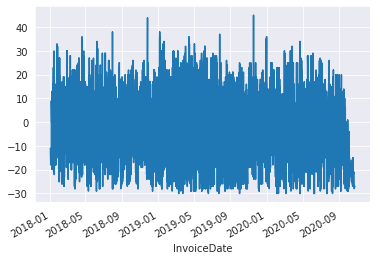

In [ ]:
univariate_df["Settle_Due"].plot()

In [ ]:
!pip install mxnet gluonts ujson
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

     |████████████████████████████████| 47.3 MB 1.5 MB/s 
     |████████████████████████████████| 2.8 MB 58.2 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 10.9 MB 32.5 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


In [ ]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
training_data = ListDataset(
    [{"start": univariate_df.index[0], "target": univariate_df.Settle_Due[:"2020-07-04T00:00:00.000000"]}],
    freq = "d"
)

In [ ]:
test_data = ListDataset(
    [{"start": univariate_df.index[0], "target": univariate_df.Settle_Due[:"2020-10-24T00:00:00.000000"]}],
    freq = "d"
)
test_data

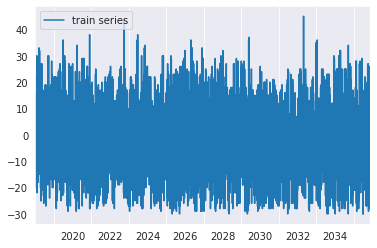

In [ ]:
entry = next(iter(training_data))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
# plt.title(entry['item_id'])
plt.show()

In [ ]:
callbacks = [
    LearningRateReduction(objective="min",
                          patience=10,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]


estimator = DeepAREstimator(
    freq="d",
    prediction_length=24,
    context_length=36,
    num_layers = 2,
    num_cells = 40,
    distr_output=StudentTOutput(),
    dropout_rate=0.01,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=500,
                    callbacks=callbacks))

predictor = estimator.train(training_data)

100%|██████████| 50/50 [00:06<00:00,  8.32it/s, epoch=494/500, avg_epoch_loss=1.94]

Early stopping based on learning rate scheduler callback (min_lr was reached).


In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [ ]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

import json
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 22.44it/s]

{
    "MSE": 328.0879720052083,
    "abs_error": 407.11920166015625,
    "abs_target_sum": 492.0,
    "abs_target_mean": 20.5,
    "seasonal_error": 13.425671812464266,
    "MASE": 1.2634972987664281,
    "MAPE": 0.7979396979014078,
    "sMAPE": 1.3159197171529133,
    "MSIS": 30.739067118413033,
    "QuantileLoss[0.1]": 530.6127407073975,
    "Coverage[0.1]": 0.875,
    "QuantileLoss[0.2]": 536.1402702331543,
    "Coverage[0.2]": 0.9583333333333334,
    "QuantileLoss[0.3]": 507.72194242477417,
    "Coverage[0.3]": 0.9583333333333334,
    "QuantileLoss[0.4]": 467.8120265007019,
    "Coverage[0.4]": 1.0,
    "QuantileLoss[0.5]": 407.119176864624,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.6]": 339.91118907928467,
    "Coverage[0.6]": 1.0,
    "QuantileLoss[0.7]": 267.0812175750733,
    "Coverage[0.7]": 1.0,
    "QuantileLoss[0.8]": 186.4294039726257,
    "Coverage[0.8]": 1.0,
    "QuantileLoss[0.9]": 100.97922210693358,
    "Coverage[0.9]": 1.0,
    "RMSE": 18.113198834143247,
    "N

DeepAR seems to perform below expectations. This could be due to the inherent nature of the data set.

**Baseline**

In [ ]:
train_date = df.iloc[0:len(df)-14,:]
test_date = df.iloc[-14:,:]

train_date.PaymentTerms
due_avg = mean(train_date.groupby('InvoiceDate').Settle_Due.mean())

test_due = test_date.groupby('InvoiceDate').Settle_Due.mean()
rmse_baseline = math.sqrt(mean((test_due-due_avg)**2))
print("RMSE baseline (if we predict with the avg of overdue time): ",rmse_baseline)

RMSE baseline (if we predict with the avg of overdue time):  12.066957941049134


**Baseline after Grouping by Partners**



In [ ]:
rmse_baseline_groupby_partners = math.sqrt(mean((mean(df_partner["Settle_Due"])-df_partner["Settle_Due"])**2))
print("RMSE baseline (if we predict with the avg of overdue time after grouping by partners): ", rmse_baseline_groupby_partners)

RMSE baseline (if we predict with the avg of overdue time after grouping by partners):  9.876862025145448


The baseline prediction works surprisingly well compared to other models we have built. This suggests the more complex models may not be necessarily suited to this particular problem.

**Clustering**

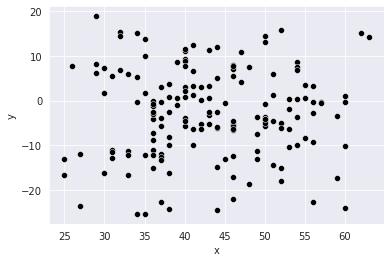

In [ ]:
# clustering based on the number of invoice for each partner
sns.scatterplot(data = df_partner, x = "Invoice Count", y= "Settle_Due", color="black")
plt.xlabel('x')
plt.ylabel('y');

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
clustering = KMeans().fit(df_partner[["Invoice Count", "Settle_Due"]])
df_partner["cluster"] = clustering.labels_

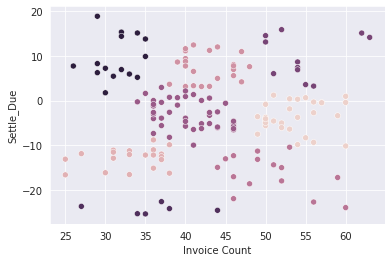

In [ ]:
sns.scatterplot(data = df_partner, x = "Invoice Count", y= "Settle_Due", hue ="cluster", legend = None)

In [ ]:
clustering.inertia_

4067.2568790640744

In [ ]:
#elbow method
from sklearn.cluster import KMeans 
inertias = [] 
mapping2 = {} 
K = np.arange(1,10)
X = df_partner[["Invoice Count", "Settle_Due"]]
    
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X)     
      
    inertias.append(kmeanModel.inertia_) 
  
    mapping2[k] = kmeanModel.inertia_ 

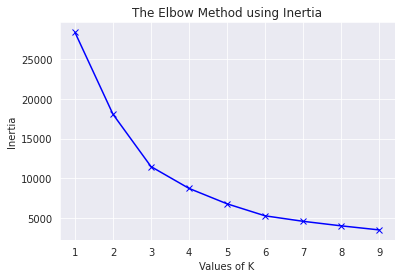

In [ ]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') ;

In [ ]:
clustering = KMeans(n_clusters=3).fit(df_partner[["Invoice Count", "Settle_Due"]])

In [ ]:
df_partner["cluster2"] = clustering.labels_

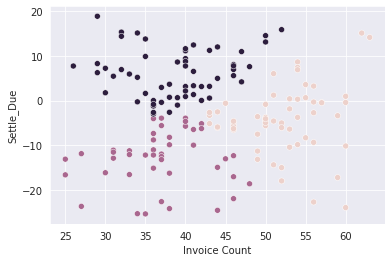

In [ ]:
sns.scatterplot(data = df_partner, x = "Invoice Count", y= "Settle_Due", hue ="cluster2", legend = None);

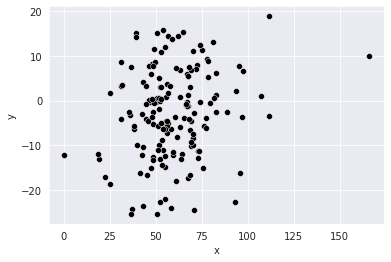

In [ ]:
# clustering based on SettledAmountUSD	for each partner
sns.scatterplot(data = df_partner, x = "SettledAmountUSD", y= "Settle_Due", color="black")
plt.xlabel('x')
plt.ylabel('y');

In [ ]:
clustering = KMeans().fit(df_partner[["SettledAmountUSD", "Settle_Due"]])
df_partner["cluster3"] = clustering.labels_

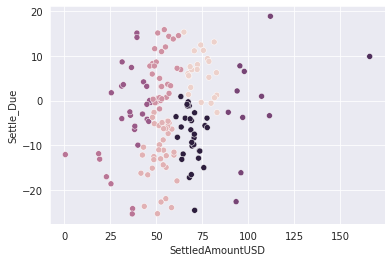

In [ ]:
sns.scatterplot(data = df_partner, x = "SettledAmountUSD", y= "Settle_Due", hue ="cluster3", legend = None)

In [ ]:
#elbow method
from sklearn.cluster import KMeans 
inertias = [] 
mapping2 = {} 
K = np.arange(1,10)
X = df_partner[["SettledAmountUSD", "Settle_Due"]]
    
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X)     
      
    inertias.append(kmeanModel.inertia_) 
  
    mapping2[k] = kmeanModel.inertia_ 

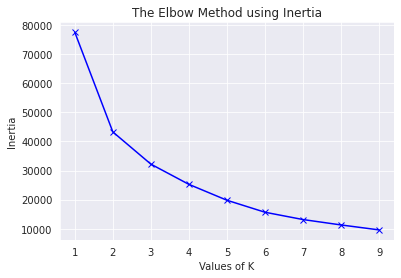

In [ ]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') ;

In [ ]:
clustering = KMeans(n_clusters=2).fit(df_partner[["SettledAmountUSD", "Settle_Due"]])

In [ ]:
df_partner["cluster4"] = clustering.labels_

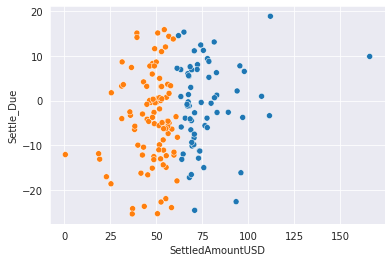

In [ ]:
sns.scatterplot(data = df_partner, x = "SettledAmountUSD", y= "Settle_Due", hue ="cluster4", legend = None)

There is no obvious link found between the amount of money being settled/the number of invoices for each partner and the date of payment.

**Comparison and Evaluation**

1. Machine learning methods, in particular XGBoost perform decently well with reference to this data set. This could be due to the use of covariates to bolster prediction power. 
2. Models in the time series forecast seem to perform below expectations. We suspect it might have to do with the inherent nature of this data set. 
3. A simple average after grouping by partners in fact performs best in predicting the date of payment. 


**Recommendation**

1. Focus on the top few firms with the highest propensity to pay late and take active precautions.
2. When evaluating the overall cash flow, factor in an average of two days in late payment to ensure the financial health. 
3. There is a dip in amount of time taken to pay/loan period towards the end of 2020, which might have impacted our predictions. It could be important to look into this with more contextual data. 